In [11]:
%matplotlib inline

In [12]:
%config InlineBackend.figure_format='retina'

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [15]:
X, y = mnist['data'], mnist['target']

In [16]:
X.shape

(70000, 784)

In [17]:
y.shape

(70000,)

In [18]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
y[36000]

5.0

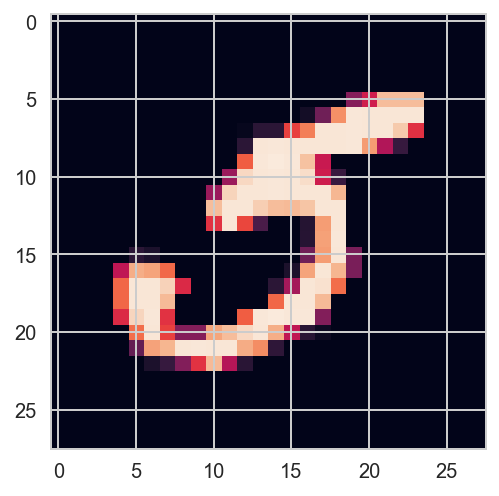

In [19]:
plt.imshow(some_digit_image, interpolation='nearest');

60000개는 학습데이터, 10000개는 검증데이터

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [21]:
shuffle_index = np.random.permutation(60000)

In [22]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [35]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

### 3.2 이진분류기 훈련

숫자 5만 식별하기

In [25]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [27]:
sgd_clf.predict([some_digit])

array([ True])

### 3.3 성능 측정

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [31]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9628
0.96425
0.95095


In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9628 , 0.96425, 0.95095])

In [37]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [38]:
never_5_clf = Never5Classifier()

In [39]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91225, 0.90655, 0.91015])

5의 데이터가 전체의 10%이기때문에 5아님 이라 예측하게 되더라도 정확도는 90%

In [45]:
np.bincount(y_train.astype(int))

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [49]:
y_train_5

array([False, False, False, ..., False, False, False])

In [48]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53494,  1085],
       [ 1355,  4066]])

In [56]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), 4066 / (4066+1085)

(0.7893612890700835, 0.7893612890700835)

In [55]:
recall_score(y_train_5, y_train_pred), 4066 / (4066+1355)

(0.7500461169525918, 0.7500461169525918)

정밀도 - 예측 결과중 맞은것 <br>
재현율 - 맞춘 비율

In [58]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7692016647748771

In [59]:
2 * (0.7893612890700835*0.7500461169525918) /  (0.7893612890700835 + 0.7500461169525918)

0.7692016647748771

In [64]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [66]:
from sklearn.metrics import precision_recall_curve

In [67]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

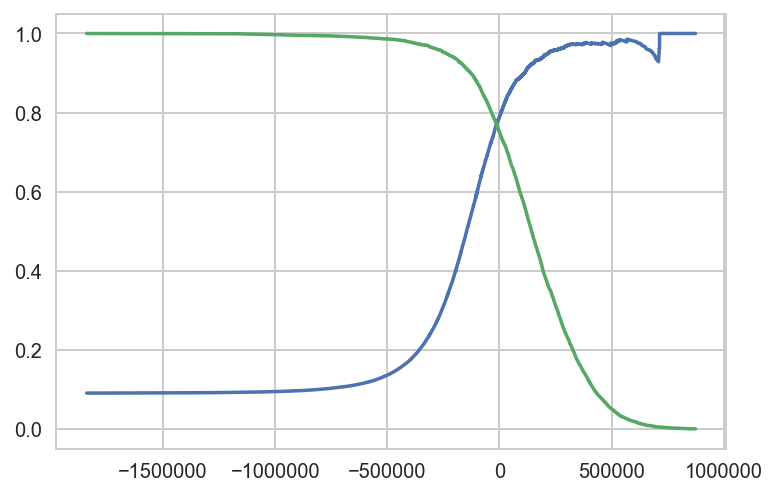

In [72]:
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])

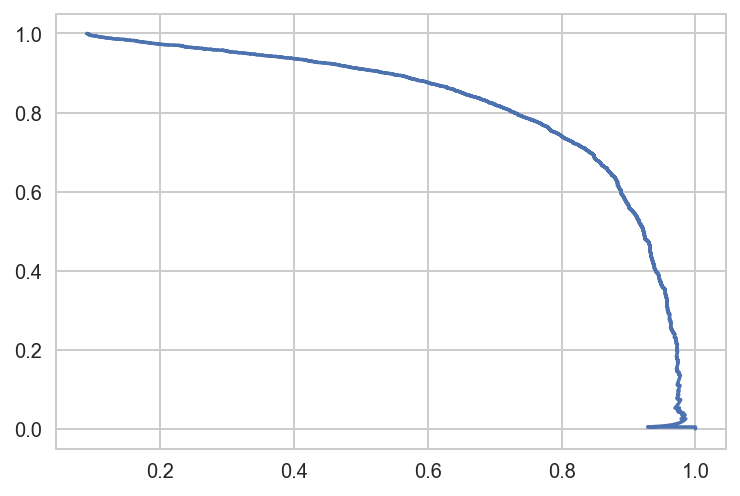

In [73]:
plt.plot(precisions, recalls)

In [74]:
y_train_pred_90 = (y_scores > 70000)

In [75]:
precision_score(y_train_5, y_train_pred_90)

0.8760414036859379

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.6401033019738056

In [77]:
from sklearn.metrics import roc_curve

In [78]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

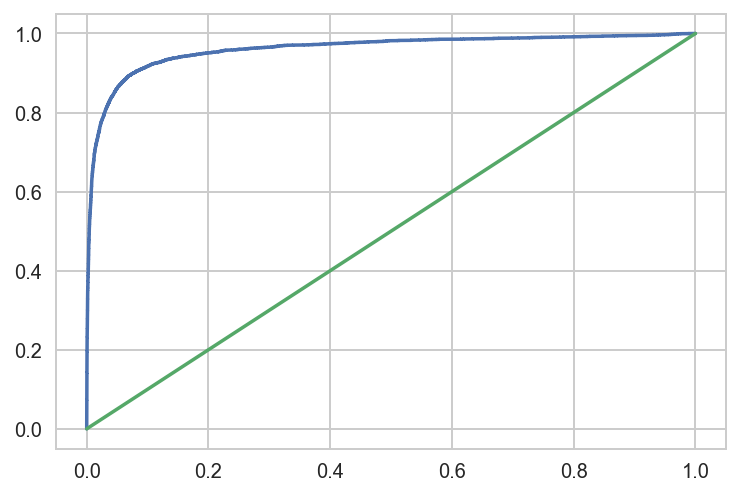

In [80]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

In [81]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [82]:
y_scores_forest = y_probas_forest[:, 1]

In [84]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

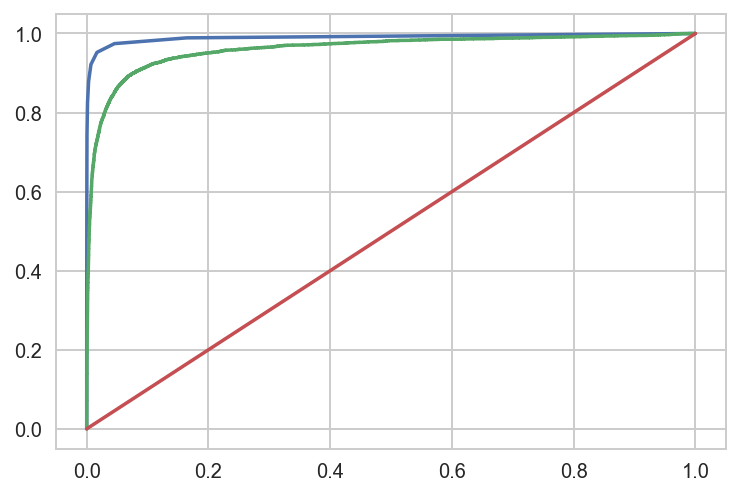

In [86]:
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

### 3.4 다중 분류기

- 랜덤포레스트 분류기, 나이브베이즈 분류기는 다중 분류 가능
- 서포트벡터머신, 선형분류기는 이진분류만 가능
- 일대다 OvA 전략
- 일대일 OvO 전략

In [92]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [93]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [94]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -21282.6846224 , -320715.91157835, -429886.26401982,
         -14536.60131611, -378105.80063926,   94143.49803969,
        -630004.64162094, -226670.7511395 , -710537.01967668,
        -629744.80950846]])

가장 높은 점수는 5가 해당

In [95]:
np.argmax(some_digit_scores)

5

In [96]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [97]:
sgd_clf.classes_[5]

5.0

In [98]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [99]:
len(ovo_clf.estimators_)

45

In [101]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [102]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [103]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88197361, 0.86099305, 0.85807871])

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90831834, 0.91079554, 0.91023654])

In [106]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5738,    3,   20,   12,   10,   49,   40,    9,   40,    2],
       [   1, 6472,   44,   23,    5,   40,    6,   10,  130,   11],
       [  51,   41, 5338,   87,   76,   26,   95,   51,  175,   18],
       [  46,   41,  148, 5336,    3,  238,   37,   50,  132,  100],
       [  17,   29,   45,    8, 5343,   10,   55,   31,   81,  223],
       [  68,   40,   37,  191,   69, 4629,  104,   27,  158,   98],
       [  31,   23,   59,    2,   38,   94, 5623,    7,   41,    0],
       [  25,   22,   74,   29,   54,   10,    4, 5785,   16,  246],
       [  51,  147,   78,  151,   10,  154,   60,   27, 5035,  138],
       [  44,   35,   27,   87,  154,   35,    2,  202,   75, 5288]])

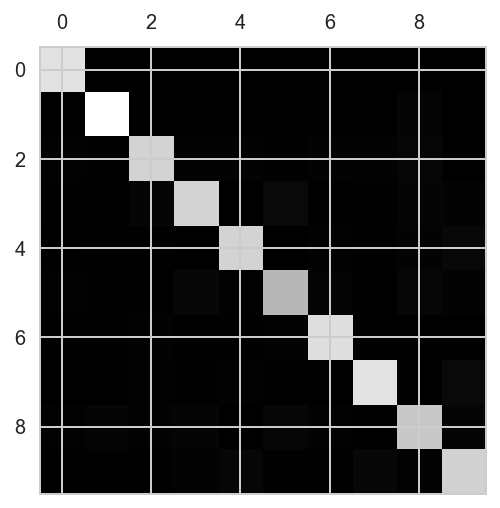

In [107]:
plt.matshow(conf_mx, cmap=plt.cm.gray);

In [111]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

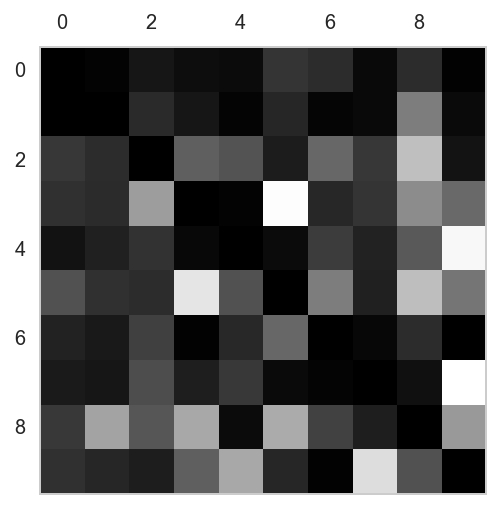

In [122]:
np.fill_diagonal(norm_conf_mx, 0 )
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.grid();

In [123]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [124]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [126]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)

Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_

KeyboardInterrupt: 

In [127]:
import random as rnd

In [131]:
noise = np.random.randint(0, 100, (len(X_train), 784))

In [132]:
X_train_mod = X_train + noise

In [133]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [134]:
y_train_mod = X_train
y_test_mod = X_test

In [136]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[30]])

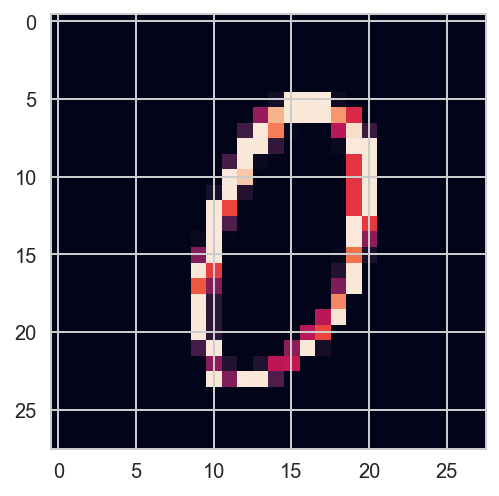

In [138]:
plt.imshow(clean_digit.reshape(28, 28))